In [1]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    numpy-1.18.5               |   py37h8960a57_0         5.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.4 MB

The following NEW packages will be INSTALLED:

  cpuonly            pytorch/noarch::cpuonly-1.0-0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5.2-hecda079_0 --> 2020.6.20-hecda079_0
  certifi                         2020.4.5.2-py37hc8dfbb8_0 --> 2020.6.20-py37hc8dfbb8_0
  numpy  

In [2]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

# **Dataset and Data Loaders**

In [3]:
# Hyperparameters
batch_size=5
learning_rate=1e-7
threshold = 0.5


# Other constants
DATASET_FILEPATH = '/kaggle/input/graduate-admissions/Admission_Predict.csv'
DATA_FILENAME = "Admission_Predict.csv"
TARGET_COLUMN = 'Chance of Admit'
input_size = 8
output_size = 1

In [4]:
df = pd.read_csv('/kaggle/input/graduate-admissions/Admission_Predict.csv')
df.rename(columns={'Chance of Admit ':'Chance of Admission'}, inplace=True)
pd.options.display.max_columns = None

df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admission
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admission'],
      dtype='object')

In [6]:
# Convert from Pandas dataframe to numpy arrays
inputs = df.drop('Chance of Admission', axis=1).values
targets = df[['Chance of Admission']].values
inputs.shape, targets.shape

((400, 8), (400, 1))

In [7]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [300, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

# **Model**

In [8]:
class AdmissionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        acc = accuracy(out, targets)       # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc' : acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))
    
model = AdmissionModel()

In [9]:
def accuracy(out, labels):
    return torch.tensor(torch.sum(abs(out-labels) < threshold).item() / len(out))

# **Training**

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
result = evaluate(model, val_loader)
result

{'val_loss': 721.9090576171875, 'val_acc': 0.030000001192092896}

In [12]:
history = fit(10000, learning_rate, model, train_loader, val_loader)

Epoch [1], val_loss: 105.1197, val_acc 0.0400
Epoch [2], val_loss: 80.8616, val_acc 0.0300
Epoch [3], val_loss: 64.7871, val_acc 0.0300
Epoch [4], val_loss: 52.5455, val_acc 0.0200
Epoch [5], val_loss: 41.9867, val_acc 0.0200
Epoch [6], val_loss: 33.3263, val_acc 0.0300
Epoch [7], val_loss: 26.2709, val_acc 0.0400
Epoch [8], val_loss: 21.2411, val_acc 0.0500
Epoch [9], val_loss: 17.1641, val_acc 0.0400
Epoch [10], val_loss: 13.6898, val_acc 0.0500
Epoch [11], val_loss: 11.0954, val_acc 0.0600
Epoch [12], val_loss: 9.0893, val_acc 0.0800
Epoch [13], val_loss: 7.4232, val_acc 0.1100
Epoch [14], val_loss: 6.1419, val_acc 0.1300
Epoch [15], val_loss: 5.1070, val_acc 0.1400
Epoch [16], val_loss: 4.3340, val_acc 0.2000
Epoch [17], val_loss: 3.6951, val_acc 0.2100
Epoch [18], val_loss: 3.2044, val_acc 0.2300
Epoch [19], val_loss: 2.8022, val_acc 0.2600
Epoch [20], val_loss: 2.4586, val_acc 0.2600
Epoch [21], val_loss: 2.2121, val_acc 0.2500
Epoch [22], val_loss: 2.0042, val_acc 0.2500
Epoch [

Epoch [187], val_loss: 1.2577, val_acc 0.4100
Epoch [188], val_loss: 1.2582, val_acc 0.4100
Epoch [189], val_loss: 1.2514, val_acc 0.4200
Epoch [190], val_loss: 1.2605, val_acc 0.4000
Epoch [191], val_loss: 1.2586, val_acc 0.4100
Epoch [192], val_loss: 1.2581, val_acc 0.4100
Epoch [193], val_loss: 1.2588, val_acc 0.4000
Epoch [194], val_loss: 1.2587, val_acc 0.4000
Epoch [195], val_loss: 1.2571, val_acc 0.4100
Epoch [196], val_loss: 1.2636, val_acc 0.3900
Epoch [197], val_loss: 1.2756, val_acc 0.3800
Epoch [198], val_loss: 1.2613, val_acc 0.3900
Epoch [199], val_loss: 1.2681, val_acc 0.3800
Epoch [200], val_loss: 1.2648, val_acc 0.3900
Epoch [201], val_loss: 1.2533, val_acc 0.4000
Epoch [202], val_loss: 1.2513, val_acc 0.4000
Epoch [203], val_loss: 1.2627, val_acc 0.3900
Epoch [204], val_loss: 1.2503, val_acc 0.4000
Epoch [205], val_loss: 1.2510, val_acc 0.4000
Epoch [206], val_loss: 1.2531, val_acc 0.4100
Epoch [207], val_loss: 1.2546, val_acc 0.4000
Epoch [208], val_loss: 1.2553, val

Epoch [370], val_loss: 1.2094, val_acc 0.4100
Epoch [371], val_loss: 1.2016, val_acc 0.4100
Epoch [372], val_loss: 1.2055, val_acc 0.4100
Epoch [373], val_loss: 1.2002, val_acc 0.4200
Epoch [374], val_loss: 1.2041, val_acc 0.4100
Epoch [375], val_loss: 1.2233, val_acc 0.3800
Epoch [376], val_loss: 1.2009, val_acc 0.4100
Epoch [377], val_loss: 1.1982, val_acc 0.4200
Epoch [378], val_loss: 1.1976, val_acc 0.4200
Epoch [379], val_loss: 1.2060, val_acc 0.4100
Epoch [380], val_loss: 1.1955, val_acc 0.4300
Epoch [381], val_loss: 1.2005, val_acc 0.4200
Epoch [382], val_loss: 1.2006, val_acc 0.4100
Epoch [383], val_loss: 1.2011, val_acc 0.4100
Epoch [384], val_loss: 1.2007, val_acc 0.4100
Epoch [385], val_loss: 1.1998, val_acc 0.4100
Epoch [386], val_loss: 1.2087, val_acc 0.4000
Epoch [387], val_loss: 1.1960, val_acc 0.4200
Epoch [388], val_loss: 1.1998, val_acc 0.4100
Epoch [389], val_loss: 1.2051, val_acc 0.4000
Epoch [390], val_loss: 1.1970, val_acc 0.4100
Epoch [391], val_loss: 1.2011, val

Epoch [554], val_loss: 1.1709, val_acc 0.3800
Epoch [555], val_loss: 1.1492, val_acc 0.4200
Epoch [556], val_loss: 1.1580, val_acc 0.4100
Epoch [557], val_loss: 1.1506, val_acc 0.4200
Epoch [558], val_loss: 1.1535, val_acc 0.4200
Epoch [559], val_loss: 1.1488, val_acc 0.4200
Epoch [560], val_loss: 1.1509, val_acc 0.4300
Epoch [561], val_loss: 1.1526, val_acc 0.4200
Epoch [562], val_loss: 1.1507, val_acc 0.4300
Epoch [563], val_loss: 1.1542, val_acc 0.4200
Epoch [564], val_loss: 1.1466, val_acc 0.4400
Epoch [565], val_loss: 1.1459, val_acc 0.4400
Epoch [566], val_loss: 1.1483, val_acc 0.4200
Epoch [567], val_loss: 1.1536, val_acc 0.4200
Epoch [568], val_loss: 1.1493, val_acc 0.4300
Epoch [569], val_loss: 1.1572, val_acc 0.4100
Epoch [570], val_loss: 1.1504, val_acc 0.4200
Epoch [571], val_loss: 1.1600, val_acc 0.4000
Epoch [572], val_loss: 1.1509, val_acc 0.4200
Epoch [573], val_loss: 1.1633, val_acc 0.3900
Epoch [574], val_loss: 1.1548, val_acc 0.4100
Epoch [575], val_loss: 1.1578, val

Epoch [734], val_loss: 1.1040, val_acc 0.4300
Epoch [735], val_loss: 1.1071, val_acc 0.4300
Epoch [736], val_loss: 1.1113, val_acc 0.4200
Epoch [737], val_loss: 1.1036, val_acc 0.4300
Epoch [738], val_loss: 1.1026, val_acc 0.4300
Epoch [739], val_loss: 1.1038, val_acc 0.4300
Epoch [740], val_loss: 1.1074, val_acc 0.4300
Epoch [741], val_loss: 1.1015, val_acc 0.4400
Epoch [742], val_loss: 1.1141, val_acc 0.4100
Epoch [743], val_loss: 1.1106, val_acc 0.4200
Epoch [744], val_loss: 1.1106, val_acc 0.4200
Epoch [745], val_loss: 1.1063, val_acc 0.4300
Epoch [746], val_loss: 1.1081, val_acc 0.4200
Epoch [747], val_loss: 1.1021, val_acc 0.4300
Epoch [748], val_loss: 1.1050, val_acc 0.4300
Epoch [749], val_loss: 1.1017, val_acc 0.4300
Epoch [750], val_loss: 1.1013, val_acc 0.4300
Epoch [751], val_loss: 1.1103, val_acc 0.4200
Epoch [752], val_loss: 1.1016, val_acc 0.4300
Epoch [753], val_loss: 1.1004, val_acc 0.4300
Epoch [754], val_loss: 1.1082, val_acc 0.4200
Epoch [755], val_loss: 1.1036, val

Epoch [916], val_loss: 1.0632, val_acc 0.4300
Epoch [917], val_loss: 1.0666, val_acc 0.4300
Epoch [918], val_loss: 1.0645, val_acc 0.4300
Epoch [919], val_loss: 1.0584, val_acc 0.4500
Epoch [920], val_loss: 1.0588, val_acc 0.4500
Epoch [921], val_loss: 1.0548, val_acc 0.4400
Epoch [922], val_loss: 1.0594, val_acc 0.4400
Epoch [923], val_loss: 1.0599, val_acc 0.4300
Epoch [924], val_loss: 1.0607, val_acc 0.4300
Epoch [925], val_loss: 1.0598, val_acc 0.4300
Epoch [926], val_loss: 1.0696, val_acc 0.4200
Epoch [927], val_loss: 1.0532, val_acc 0.4400
Epoch [928], val_loss: 1.0548, val_acc 0.4400
Epoch [929], val_loss: 1.0650, val_acc 0.4200
Epoch [930], val_loss: 1.0576, val_acc 0.4400
Epoch [931], val_loss: 1.0586, val_acc 0.4300
Epoch [932], val_loss: 1.0566, val_acc 0.4400
Epoch [933], val_loss: 1.0525, val_acc 0.4400
Epoch [934], val_loss: 1.0540, val_acc 0.4500
Epoch [935], val_loss: 1.0529, val_acc 0.4400
Epoch [936], val_loss: 1.0551, val_acc 0.4500
Epoch [937], val_loss: 1.0532, val

Epoch [1099], val_loss: 1.0162, val_acc 0.4500
Epoch [1100], val_loss: 1.0190, val_acc 0.4400
Epoch [1101], val_loss: 1.0320, val_acc 0.4300
Epoch [1102], val_loss: 1.0167, val_acc 0.4500
Epoch [1103], val_loss: 1.0216, val_acc 0.4300
Epoch [1104], val_loss: 1.0140, val_acc 0.4500
Epoch [1105], val_loss: 1.0192, val_acc 0.4400
Epoch [1106], val_loss: 1.0105, val_acc 0.4500
Epoch [1107], val_loss: 1.0167, val_acc 0.4500
Epoch [1108], val_loss: 1.0237, val_acc 0.4300
Epoch [1109], val_loss: 1.0155, val_acc 0.4500
Epoch [1110], val_loss: 1.0119, val_acc 0.4500
Epoch [1111], val_loss: 1.0202, val_acc 0.4300
Epoch [1112], val_loss: 1.0127, val_acc 0.4500
Epoch [1113], val_loss: 1.0179, val_acc 0.4300
Epoch [1114], val_loss: 1.0170, val_acc 0.4400
Epoch [1115], val_loss: 1.0126, val_acc 0.4500
Epoch [1116], val_loss: 1.0097, val_acc 0.4500
Epoch [1117], val_loss: 1.0208, val_acc 0.4300
Epoch [1118], val_loss: 1.0104, val_acc 0.4500
Epoch [1119], val_loss: 1.0094, val_acc 0.4500
Epoch [1120],

Epoch [1274], val_loss: 0.9775, val_acc 0.4500
Epoch [1275], val_loss: 0.9848, val_acc 0.4400
Epoch [1276], val_loss: 0.9789, val_acc 0.4500
Epoch [1277], val_loss: 0.9756, val_acc 0.4600
Epoch [1278], val_loss: 0.9771, val_acc 0.4500
Epoch [1279], val_loss: 0.9729, val_acc 0.4600
Epoch [1280], val_loss: 0.9746, val_acc 0.4600
Epoch [1281], val_loss: 0.9811, val_acc 0.4400
Epoch [1282], val_loss: 0.9748, val_acc 0.4600
Epoch [1283], val_loss: 0.9781, val_acc 0.4500
Epoch [1284], val_loss: 0.9795, val_acc 0.4500
Epoch [1285], val_loss: 0.9747, val_acc 0.4600
Epoch [1286], val_loss: 0.9782, val_acc 0.4500
Epoch [1287], val_loss: 0.9731, val_acc 0.4600
Epoch [1288], val_loss: 0.9762, val_acc 0.4500
Epoch [1289], val_loss: 0.9733, val_acc 0.4600
Epoch [1290], val_loss: 0.9755, val_acc 0.4500
Epoch [1291], val_loss: 0.9780, val_acc 0.4500
Epoch [1292], val_loss: 0.9694, val_acc 0.4600
Epoch [1293], val_loss: 0.9758, val_acc 0.4500
Epoch [1294], val_loss: 0.9700, val_acc 0.4600
Epoch [1295],

Epoch [1455], val_loss: 0.9399, val_acc 0.4600
Epoch [1456], val_loss: 0.9401, val_acc 0.4600
Epoch [1457], val_loss: 0.9366, val_acc 0.4600
Epoch [1458], val_loss: 0.9390, val_acc 0.4600
Epoch [1459], val_loss: 0.9452, val_acc 0.4400
Epoch [1460], val_loss: 0.9370, val_acc 0.4600
Epoch [1461], val_loss: 0.9433, val_acc 0.4500
Epoch [1462], val_loss: 0.9421, val_acc 0.4500
Epoch [1463], val_loss: 0.9417, val_acc 0.4500
Epoch [1464], val_loss: 0.9375, val_acc 0.4600
Epoch [1465], val_loss: 0.9315, val_acc 0.4600
Epoch [1466], val_loss: 0.9397, val_acc 0.4600
Epoch [1467], val_loss: 0.9317, val_acc 0.4600
Epoch [1468], val_loss: 0.9362, val_acc 0.4600
Epoch [1469], val_loss: 0.9417, val_acc 0.4500
Epoch [1470], val_loss: 0.9377, val_acc 0.4600
Epoch [1471], val_loss: 0.9377, val_acc 0.4600
Epoch [1472], val_loss: 0.9318, val_acc 0.4600
Epoch [1473], val_loss: 0.9316, val_acc 0.4600
Epoch [1474], val_loss: 0.9307, val_acc 0.4600
Epoch [1475], val_loss: 0.9331, val_acc 0.4600
Epoch [1476],

Epoch [1634], val_loss: 0.9007, val_acc 0.4600
Epoch [1635], val_loss: 0.9080, val_acc 0.4600
Epoch [1636], val_loss: 0.8966, val_acc 0.4600
Epoch [1637], val_loss: 0.8951, val_acc 0.4600
Epoch [1638], val_loss: 0.8952, val_acc 0.4700
Epoch [1639], val_loss: 0.8987, val_acc 0.4600
Epoch [1640], val_loss: 0.8980, val_acc 0.4600
Epoch [1641], val_loss: 0.8936, val_acc 0.4700
Epoch [1642], val_loss: 0.8952, val_acc 0.4600
Epoch [1643], val_loss: 0.9019, val_acc 0.4600
Epoch [1644], val_loss: 0.9035, val_acc 0.4600
Epoch [1645], val_loss: 0.8986, val_acc 0.4600
Epoch [1646], val_loss: 0.8988, val_acc 0.4600
Epoch [1647], val_loss: 0.8993, val_acc 0.4600
Epoch [1648], val_loss: 0.9067, val_acc 0.4600
Epoch [1649], val_loss: 0.9019, val_acc 0.4600
Epoch [1650], val_loss: 0.9010, val_acc 0.4600
Epoch [1651], val_loss: 0.8945, val_acc 0.4600
Epoch [1652], val_loss: 0.8984, val_acc 0.4600
Epoch [1653], val_loss: 0.8959, val_acc 0.4600
Epoch [1654], val_loss: 0.8987, val_acc 0.4600
Epoch [1655],

Epoch [1814], val_loss: 0.8632, val_acc 0.4600
Epoch [1815], val_loss: 0.8664, val_acc 0.4600
Epoch [1816], val_loss: 0.8752, val_acc 0.4700
Epoch [1817], val_loss: 0.8648, val_acc 0.4600
Epoch [1818], val_loss: 0.8645, val_acc 0.4600
Epoch [1819], val_loss: 0.8607, val_acc 0.4800
Epoch [1820], val_loss: 0.8613, val_acc 0.4600
Epoch [1821], val_loss: 0.8597, val_acc 0.4800
Epoch [1822], val_loss: 0.8629, val_acc 0.4600
Epoch [1823], val_loss: 0.8658, val_acc 0.4600
Epoch [1824], val_loss: 0.8611, val_acc 0.4600
Epoch [1825], val_loss: 0.8652, val_acc 0.4600
Epoch [1826], val_loss: 0.8661, val_acc 0.4600
Epoch [1827], val_loss: 0.8613, val_acc 0.4600
Epoch [1828], val_loss: 0.8592, val_acc 0.4800
Epoch [1829], val_loss: 0.8678, val_acc 0.4600
Epoch [1830], val_loss: 0.8713, val_acc 0.4600
Epoch [1831], val_loss: 0.8603, val_acc 0.4600
Epoch [1832], val_loss: 0.8601, val_acc 0.4600
Epoch [1833], val_loss: 0.8584, val_acc 0.4800
Epoch [1834], val_loss: 0.8631, val_acc 0.4600
Epoch [1835],

Epoch [1989], val_loss: 0.8296, val_acc 0.4800
Epoch [1990], val_loss: 0.8290, val_acc 0.4800
Epoch [1991], val_loss: 0.8281, val_acc 0.4800
Epoch [1992], val_loss: 0.8329, val_acc 0.4600
Epoch [1993], val_loss: 0.8326, val_acc 0.4600
Epoch [1994], val_loss: 0.8368, val_acc 0.4600
Epoch [1995], val_loss: 0.8350, val_acc 0.4600
Epoch [1996], val_loss: 0.8275, val_acc 0.4800
Epoch [1997], val_loss: 0.8294, val_acc 0.4700
Epoch [1998], val_loss: 0.8284, val_acc 0.4800
Epoch [1999], val_loss: 0.8377, val_acc 0.4600
Epoch [2000], val_loss: 0.8258, val_acc 0.4800
Epoch [2001], val_loss: 0.8313, val_acc 0.4600
Epoch [2002], val_loss: 0.8250, val_acc 0.4800
Epoch [2003], val_loss: 0.8241, val_acc 0.4700
Epoch [2004], val_loss: 0.8341, val_acc 0.4600
Epoch [2005], val_loss: 0.8263, val_acc 0.4800
Epoch [2006], val_loss: 0.8242, val_acc 0.4800
Epoch [2007], val_loss: 0.8278, val_acc 0.4700
Epoch [2008], val_loss: 0.8284, val_acc 0.4700
Epoch [2009], val_loss: 0.8271, val_acc 0.4700
Epoch [2010],

Epoch [2168], val_loss: 0.7993, val_acc 0.4700
Epoch [2169], val_loss: 0.7985, val_acc 0.4800
Epoch [2170], val_loss: 0.7995, val_acc 0.4700
Epoch [2171], val_loss: 0.7964, val_acc 0.4800
Epoch [2172], val_loss: 0.7967, val_acc 0.4800
Epoch [2173], val_loss: 0.7937, val_acc 0.4800
Epoch [2174], val_loss: 0.7998, val_acc 0.4700
Epoch [2175], val_loss: 0.8031, val_acc 0.4700
Epoch [2176], val_loss: 0.7963, val_acc 0.4800
Epoch [2177], val_loss: 0.7978, val_acc 0.4700
Epoch [2178], val_loss: 0.7978, val_acc 0.4700
Epoch [2179], val_loss: 0.7970, val_acc 0.4800
Epoch [2180], val_loss: 0.7960, val_acc 0.4800
Epoch [2181], val_loss: 0.7992, val_acc 0.4700
Epoch [2182], val_loss: 0.7967, val_acc 0.4800
Epoch [2183], val_loss: 0.7942, val_acc 0.4800
Epoch [2184], val_loss: 0.7979, val_acc 0.4700
Epoch [2185], val_loss: 0.7939, val_acc 0.4800
Epoch [2186], val_loss: 0.7997, val_acc 0.4700
Epoch [2187], val_loss: 0.7948, val_acc 0.4800
Epoch [2188], val_loss: 0.7973, val_acc 0.4700
Epoch [2189],

Epoch [2346], val_loss: 0.7703, val_acc 0.4700
Epoch [2347], val_loss: 0.7685, val_acc 0.4800
Epoch [2348], val_loss: 0.7674, val_acc 0.4800
Epoch [2349], val_loss: 0.7768, val_acc 0.4900
Epoch [2350], val_loss: 0.7652, val_acc 0.4800
Epoch [2351], val_loss: 0.7659, val_acc 0.4800
Epoch [2352], val_loss: 0.7701, val_acc 0.4700
Epoch [2353], val_loss: 0.7709, val_acc 0.4700
Epoch [2354], val_loss: 0.7676, val_acc 0.4800
Epoch [2355], val_loss: 0.7661, val_acc 0.4800
Epoch [2356], val_loss: 0.7648, val_acc 0.4800
Epoch [2357], val_loss: 0.7677, val_acc 0.4800
Epoch [2358], val_loss: 0.7687, val_acc 0.4700
Epoch [2359], val_loss: 0.7639, val_acc 0.4800
Epoch [2360], val_loss: 0.7654, val_acc 0.4800
Epoch [2361], val_loss: 0.7650, val_acc 0.4800
Epoch [2362], val_loss: 0.7656, val_acc 0.4800
Epoch [2363], val_loss: 0.7675, val_acc 0.4800
Epoch [2364], val_loss: 0.7646, val_acc 0.4800
Epoch [2365], val_loss: 0.7653, val_acc 0.4800
Epoch [2366], val_loss: 0.7660, val_acc 0.4800
Epoch [2367],

Epoch [2521], val_loss: 0.7457, val_acc 0.4800
Epoch [2522], val_loss: 0.7410, val_acc 0.4800
Epoch [2523], val_loss: 0.7385, val_acc 0.4800
Epoch [2524], val_loss: 0.7362, val_acc 0.4800
Epoch [2525], val_loss: 0.7358, val_acc 0.4800
Epoch [2526], val_loss: 0.7397, val_acc 0.4800
Epoch [2527], val_loss: 0.7378, val_acc 0.4800
Epoch [2528], val_loss: 0.7363, val_acc 0.4800
Epoch [2529], val_loss: 0.7409, val_acc 0.4800
Epoch [2530], val_loss: 0.7424, val_acc 0.4800
Epoch [2531], val_loss: 0.7362, val_acc 0.4800
Epoch [2532], val_loss: 0.7386, val_acc 0.4800
Epoch [2533], val_loss: 0.7387, val_acc 0.4800
Epoch [2534], val_loss: 0.7398, val_acc 0.4800
Epoch [2535], val_loss: 0.7373, val_acc 0.4800
Epoch [2536], val_loss: 0.7350, val_acc 0.4800
Epoch [2537], val_loss: 0.7375, val_acc 0.4800
Epoch [2538], val_loss: 0.7372, val_acc 0.4800
Epoch [2539], val_loss: 0.7371, val_acc 0.4800
Epoch [2540], val_loss: 0.7340, val_acc 0.4800
Epoch [2541], val_loss: 0.7362, val_acc 0.4800
Epoch [2542],

Epoch [2698], val_loss: 0.7084, val_acc 0.4800
Epoch [2699], val_loss: 0.7131, val_acc 0.4900
Epoch [2700], val_loss: 0.7078, val_acc 0.4800
Epoch [2701], val_loss: 0.7100, val_acc 0.4800
Epoch [2702], val_loss: 0.7111, val_acc 0.4800
Epoch [2703], val_loss: 0.7107, val_acc 0.4800
Epoch [2704], val_loss: 0.7085, val_acc 0.4800
Epoch [2705], val_loss: 0.7070, val_acc 0.4800
Epoch [2706], val_loss: 0.7128, val_acc 0.4900
Epoch [2707], val_loss: 0.7116, val_acc 0.4900
Epoch [2708], val_loss: 0.7113, val_acc 0.4900
Epoch [2709], val_loss: 0.7102, val_acc 0.4900
Epoch [2710], val_loss: 0.7091, val_acc 0.4800
Epoch [2711], val_loss: 0.7105, val_acc 0.4900
Epoch [2712], val_loss: 0.7069, val_acc 0.4800
Epoch [2713], val_loss: 0.7054, val_acc 0.4900
Epoch [2714], val_loss: 0.7074, val_acc 0.4800
Epoch [2715], val_loss: 0.7088, val_acc 0.4800
Epoch [2716], val_loss: 0.7072, val_acc 0.4800
Epoch [2717], val_loss: 0.7083, val_acc 0.4800
Epoch [2718], val_loss: 0.7100, val_acc 0.4900
Epoch [2719],

Epoch [2878], val_loss: 0.6815, val_acc 0.4800
Epoch [2879], val_loss: 0.6828, val_acc 0.4900
Epoch [2880], val_loss: 0.6842, val_acc 0.4900
Epoch [2881], val_loss: 0.6834, val_acc 0.4900
Epoch [2882], val_loss: 0.6858, val_acc 0.4900
Epoch [2883], val_loss: 0.6850, val_acc 0.4900
Epoch [2884], val_loss: 0.6833, val_acc 0.4900
Epoch [2885], val_loss: 0.6813, val_acc 0.4800
Epoch [2886], val_loss: 0.6866, val_acc 0.4900
Epoch [2887], val_loss: 0.6846, val_acc 0.4900
Epoch [2888], val_loss: 0.6850, val_acc 0.4900
Epoch [2889], val_loss: 0.6855, val_acc 0.4900
Epoch [2890], val_loss: 0.6800, val_acc 0.4800
Epoch [2891], val_loss: 0.6808, val_acc 0.4900
Epoch [2892], val_loss: 0.6859, val_acc 0.4900
Epoch [2893], val_loss: 0.6803, val_acc 0.4900
Epoch [2894], val_loss: 0.6803, val_acc 0.4900
Epoch [2895], val_loss: 0.6806, val_acc 0.4900
Epoch [2896], val_loss: 0.6834, val_acc 0.4900
Epoch [2897], val_loss: 0.6846, val_acc 0.4900
Epoch [2898], val_loss: 0.6873, val_acc 0.4900
Epoch [2899],

Epoch [3057], val_loss: 0.6614, val_acc 0.4900
Epoch [3058], val_loss: 0.6609, val_acc 0.4900
Epoch [3059], val_loss: 0.6623, val_acc 0.4900
Epoch [3060], val_loss: 0.6649, val_acc 0.5100
Epoch [3061], val_loss: 0.6572, val_acc 0.4900
Epoch [3062], val_loss: 0.6566, val_acc 0.4900
Epoch [3063], val_loss: 0.6586, val_acc 0.4900
Epoch [3064], val_loss: 0.6606, val_acc 0.4900
Epoch [3065], val_loss: 0.6574, val_acc 0.4900
Epoch [3066], val_loss: 0.6575, val_acc 0.4900
Epoch [3067], val_loss: 0.6584, val_acc 0.4900
Epoch [3068], val_loss: 0.6611, val_acc 0.4900
Epoch [3069], val_loss: 0.6583, val_acc 0.4900
Epoch [3070], val_loss: 0.6599, val_acc 0.4900
Epoch [3071], val_loss: 0.6563, val_acc 0.4900
Epoch [3072], val_loss: 0.6590, val_acc 0.4900
Epoch [3073], val_loss: 0.6558, val_acc 0.4900
Epoch [3074], val_loss: 0.6578, val_acc 0.4900
Epoch [3075], val_loss: 0.6541, val_acc 0.4900
Epoch [3076], val_loss: 0.6587, val_acc 0.4900
Epoch [3077], val_loss: 0.6598, val_acc 0.4900
Epoch [3078],

Epoch [3232], val_loss: 0.6351, val_acc 0.4900
Epoch [3233], val_loss: 0.6330, val_acc 0.4900
Epoch [3234], val_loss: 0.6360, val_acc 0.4900
Epoch [3235], val_loss: 0.6399, val_acc 0.5200
Epoch [3236], val_loss: 0.6358, val_acc 0.4900
Epoch [3237], val_loss: 0.6359, val_acc 0.5000
Epoch [3238], val_loss: 0.6322, val_acc 0.4900
Epoch [3239], val_loss: 0.6330, val_acc 0.4900
Epoch [3240], val_loss: 0.6351, val_acc 0.4900
Epoch [3241], val_loss: 0.6338, val_acc 0.4900
Epoch [3242], val_loss: 0.6321, val_acc 0.4900
Epoch [3243], val_loss: 0.6346, val_acc 0.4900
Epoch [3244], val_loss: 0.6331, val_acc 0.4900
Epoch [3245], val_loss: 0.6324, val_acc 0.4900
Epoch [3246], val_loss: 0.6340, val_acc 0.4900
Epoch [3247], val_loss: 0.6349, val_acc 0.5000
Epoch [3248], val_loss: 0.6318, val_acc 0.4900
Epoch [3249], val_loss: 0.6324, val_acc 0.4900
Epoch [3250], val_loss: 0.6339, val_acc 0.5000
Epoch [3251], val_loss: 0.6378, val_acc 0.5200
Epoch [3252], val_loss: 0.6365, val_acc 0.5100
Epoch [3253],

Epoch [3414], val_loss: 0.6119, val_acc 0.5000
Epoch [3415], val_loss: 0.6133, val_acc 0.5100
Epoch [3416], val_loss: 0.6113, val_acc 0.5000
Epoch [3417], val_loss: 0.6092, val_acc 0.5000
Epoch [3418], val_loss: 0.6111, val_acc 0.5000
Epoch [3419], val_loss: 0.6088, val_acc 0.5000
Epoch [3420], val_loss: 0.6168, val_acc 0.5300
Epoch [3421], val_loss: 0.6137, val_acc 0.5200
Epoch [3422], val_loss: 0.6132, val_acc 0.5200
Epoch [3423], val_loss: 0.6107, val_acc 0.5000
Epoch [3424], val_loss: 0.6098, val_acc 0.5000
Epoch [3425], val_loss: 0.6077, val_acc 0.5000
Epoch [3426], val_loss: 0.6095, val_acc 0.5000
Epoch [3427], val_loss: 0.6143, val_acc 0.5300
Epoch [3428], val_loss: 0.6118, val_acc 0.5200
Epoch [3429], val_loss: 0.6105, val_acc 0.5100
Epoch [3430], val_loss: 0.6118, val_acc 0.5200
Epoch [3431], val_loss: 0.6083, val_acc 0.4900
Epoch [3432], val_loss: 0.6063, val_acc 0.5000
Epoch [3433], val_loss: 0.6099, val_acc 0.5100
Epoch [3434], val_loss: 0.6085, val_acc 0.5000
Epoch [3435],

Epoch [3593], val_loss: 0.5901, val_acc 0.5200
Epoch [3594], val_loss: 0.5886, val_acc 0.5200
Epoch [3595], val_loss: 0.5898, val_acc 0.5200
Epoch [3596], val_loss: 0.5862, val_acc 0.5100
Epoch [3597], val_loss: 0.5898, val_acc 0.5200
Epoch [3598], val_loss: 0.5879, val_acc 0.5100
Epoch [3599], val_loss: 0.5889, val_acc 0.5200
Epoch [3600], val_loss: 0.5883, val_acc 0.5200
Epoch [3601], val_loss: 0.5881, val_acc 0.5200
Epoch [3602], val_loss: 0.5931, val_acc 0.5300
Epoch [3603], val_loss: 0.5914, val_acc 0.5200
Epoch [3604], val_loss: 0.5850, val_acc 0.5100
Epoch [3605], val_loss: 0.5885, val_acc 0.5200
Epoch [3606], val_loss: 0.5893, val_acc 0.5200
Epoch [3607], val_loss: 0.5877, val_acc 0.5200
Epoch [3608], val_loss: 0.5885, val_acc 0.5200
Epoch [3609], val_loss: 0.5866, val_acc 0.5200
Epoch [3610], val_loss: 0.5901, val_acc 0.5200
Epoch [3611], val_loss: 0.5887, val_acc 0.5200
Epoch [3612], val_loss: 0.5860, val_acc 0.5200
Epoch [3613], val_loss: 0.5871, val_acc 0.5200
Epoch [3614],

Epoch [3773], val_loss: 0.5660, val_acc 0.5400
Epoch [3774], val_loss: 0.5656, val_acc 0.5300
Epoch [3775], val_loss: 0.5681, val_acc 0.5200
Epoch [3776], val_loss: 0.5647, val_acc 0.5300
Epoch [3777], val_loss: 0.5686, val_acc 0.5200
Epoch [3778], val_loss: 0.5660, val_acc 0.5300
Epoch [3779], val_loss: 0.5719, val_acc 0.5400
Epoch [3780], val_loss: 0.5669, val_acc 0.5200
Epoch [3781], val_loss: 0.5666, val_acc 0.5300
Epoch [3782], val_loss: 0.5686, val_acc 0.5200
Epoch [3783], val_loss: 0.5659, val_acc 0.5300
Epoch [3784], val_loss: 0.5646, val_acc 0.5400
Epoch [3785], val_loss: 0.5663, val_acc 0.5200
Epoch [3786], val_loss: 0.5681, val_acc 0.5200
Epoch [3787], val_loss: 0.5683, val_acc 0.5300
Epoch [3788], val_loss: 0.5659, val_acc 0.5200
Epoch [3789], val_loss: 0.5647, val_acc 0.5300
Epoch [3790], val_loss: 0.5680, val_acc 0.5300
Epoch [3791], val_loss: 0.5641, val_acc 0.5400
Epoch [3792], val_loss: 0.5655, val_acc 0.5200
Epoch [3793], val_loss: 0.5653, val_acc 0.5200
Epoch [3794],

Epoch [3953], val_loss: 0.5461, val_acc 0.5400
Epoch [3954], val_loss: 0.5451, val_acc 0.5600
Epoch [3955], val_loss: 0.5459, val_acc 0.5400
Epoch [3956], val_loss: 0.5511, val_acc 0.5400
Epoch [3957], val_loss: 0.5526, val_acc 0.5300
Epoch [3958], val_loss: 0.5473, val_acc 0.5400
Epoch [3959], val_loss: 0.5496, val_acc 0.5400
Epoch [3960], val_loss: 0.5452, val_acc 0.5400
Epoch [3961], val_loss: 0.5449, val_acc 0.5500
Epoch [3962], val_loss: 0.5495, val_acc 0.5400
Epoch [3963], val_loss: 0.5455, val_acc 0.5400
Epoch [3964], val_loss: 0.5477, val_acc 0.5300
Epoch [3965], val_loss: 0.5464, val_acc 0.5400
Epoch [3966], val_loss: 0.5434, val_acc 0.5600
Epoch [3967], val_loss: 0.5476, val_acc 0.5300
Epoch [3968], val_loss: 0.5524, val_acc 0.5300
Epoch [3969], val_loss: 0.5442, val_acc 0.5500
Epoch [3970], val_loss: 0.5446, val_acc 0.5400
Epoch [3971], val_loss: 0.5434, val_acc 0.5600
Epoch [3972], val_loss: 0.5434, val_acc 0.5600
Epoch [3973], val_loss: 0.5446, val_acc 0.5500
Epoch [3974],

Epoch [4133], val_loss: 0.5269, val_acc 0.5700
Epoch [4134], val_loss: 0.5316, val_acc 0.5400
Epoch [4135], val_loss: 0.5284, val_acc 0.5500
Epoch [4136], val_loss: 0.5252, val_acc 0.5600
Epoch [4137], val_loss: 0.5280, val_acc 0.5500
Epoch [4138], val_loss: 0.5257, val_acc 0.5700
Epoch [4139], val_loss: 0.5254, val_acc 0.5600
Epoch [4140], val_loss: 0.5251, val_acc 0.5600
Epoch [4141], val_loss: 0.5272, val_acc 0.5500
Epoch [4142], val_loss: 0.5248, val_acc 0.5600
Epoch [4143], val_loss: 0.5266, val_acc 0.5600
Epoch [4144], val_loss: 0.5263, val_acc 0.5600
Epoch [4145], val_loss: 0.5246, val_acc 0.5600
Epoch [4146], val_loss: 0.5289, val_acc 0.5300
Epoch [4147], val_loss: 0.5241, val_acc 0.5600
Epoch [4148], val_loss: 0.5269, val_acc 0.5500
Epoch [4149], val_loss: 0.5270, val_acc 0.5500
Epoch [4150], val_loss: 0.5261, val_acc 0.5600
Epoch [4151], val_loss: 0.5279, val_acc 0.5400
Epoch [4152], val_loss: 0.5263, val_acc 0.5500
Epoch [4153], val_loss: 0.5345, val_acc 0.5300
Epoch [4154],

Epoch [4314], val_loss: 0.5071, val_acc 0.5700
Epoch [4315], val_loss: 0.5086, val_acc 0.5700
Epoch [4316], val_loss: 0.5094, val_acc 0.5700
Epoch [4317], val_loss: 0.5123, val_acc 0.5500
Epoch [4318], val_loss: 0.5109, val_acc 0.5600
Epoch [4319], val_loss: 0.5091, val_acc 0.5700
Epoch [4320], val_loss: 0.5084, val_acc 0.5700
Epoch [4321], val_loss: 0.5076, val_acc 0.5700
Epoch [4322], val_loss: 0.5117, val_acc 0.5500
Epoch [4323], val_loss: 0.5083, val_acc 0.5700
Epoch [4324], val_loss: 0.5105, val_acc 0.5600
Epoch [4325], val_loss: 0.5078, val_acc 0.5700
Epoch [4326], val_loss: 0.5120, val_acc 0.5500
Epoch [4327], val_loss: 0.5099, val_acc 0.5600
Epoch [4328], val_loss: 0.5098, val_acc 0.5600
Epoch [4329], val_loss: 0.5098, val_acc 0.5600
Epoch [4330], val_loss: 0.5111, val_acc 0.5500
Epoch [4331], val_loss: 0.5100, val_acc 0.5600
Epoch [4332], val_loss: 0.5088, val_acc 0.5600
Epoch [4333], val_loss: 0.5108, val_acc 0.5500
Epoch [4334], val_loss: 0.5100, val_acc 0.5500
Epoch [4335],

Epoch [4489], val_loss: 0.4919, val_acc 0.5700
Epoch [4490], val_loss: 0.4918, val_acc 0.5700
Epoch [4491], val_loss: 0.4916, val_acc 0.5700
Epoch [4492], val_loss: 0.4917, val_acc 0.5700
Epoch [4493], val_loss: 0.4911, val_acc 0.5700
Epoch [4494], val_loss: 0.4901, val_acc 0.5700
Epoch [4495], val_loss: 0.4979, val_acc 0.5300
Epoch [4496], val_loss: 0.4901, val_acc 0.5700
Epoch [4497], val_loss: 0.4893, val_acc 0.5700
Epoch [4498], val_loss: 0.4908, val_acc 0.5700
Epoch [4499], val_loss: 0.4913, val_acc 0.5700
Epoch [4500], val_loss: 0.4919, val_acc 0.5700
Epoch [4501], val_loss: 0.4909, val_acc 0.5700
Epoch [4502], val_loss: 0.4942, val_acc 0.5700
Epoch [4503], val_loss: 0.4908, val_acc 0.5700
Epoch [4504], val_loss: 0.4904, val_acc 0.5700
Epoch [4505], val_loss: 0.4906, val_acc 0.5700
Epoch [4506], val_loss: 0.4899, val_acc 0.5700
Epoch [4507], val_loss: 0.4929, val_acc 0.5700
Epoch [4508], val_loss: 0.4921, val_acc 0.5700
Epoch [4509], val_loss: 0.4894, val_acc 0.5700
Epoch [4510],

Epoch [4669], val_loss: 0.4788, val_acc 0.5600
Epoch [4670], val_loss: 0.4782, val_acc 0.5700
Epoch [4671], val_loss: 0.4781, val_acc 0.5700
Epoch [4672], val_loss: 0.4743, val_acc 0.5700
Epoch [4673], val_loss: 0.4763, val_acc 0.5800
Epoch [4674], val_loss: 0.4744, val_acc 0.5700
Epoch [4675], val_loss: 0.4777, val_acc 0.5700
Epoch [4676], val_loss: 0.4774, val_acc 0.5700
Epoch [4677], val_loss: 0.4741, val_acc 0.5700
Epoch [4678], val_loss: 0.4738, val_acc 0.5700
Epoch [4679], val_loss: 0.4736, val_acc 0.5700
Epoch [4680], val_loss: 0.4745, val_acc 0.5700
Epoch [4681], val_loss: 0.4755, val_acc 0.5800
Epoch [4682], val_loss: 0.4762, val_acc 0.5800
Epoch [4683], val_loss: 0.4739, val_acc 0.5700
Epoch [4684], val_loss: 0.4763, val_acc 0.5800
Epoch [4685], val_loss: 0.4746, val_acc 0.5700
Epoch [4686], val_loss: 0.4720, val_acc 0.5700
Epoch [4687], val_loss: 0.4787, val_acc 0.5500
Epoch [4688], val_loss: 0.4733, val_acc 0.5700
Epoch [4689], val_loss: 0.4716, val_acc 0.5700
Epoch [4690],

Epoch [4845], val_loss: 0.4613, val_acc 0.5800
Epoch [4846], val_loss: 0.4673, val_acc 0.5600
Epoch [4847], val_loss: 0.4584, val_acc 0.5700
Epoch [4848], val_loss: 0.4597, val_acc 0.5700
Epoch [4849], val_loss: 0.4596, val_acc 0.5700
Epoch [4850], val_loss: 0.4632, val_acc 0.5700
Epoch [4851], val_loss: 0.4600, val_acc 0.5800
Epoch [4852], val_loss: 0.4610, val_acc 0.5800
Epoch [4853], val_loss: 0.4610, val_acc 0.5700
Epoch [4854], val_loss: 0.4605, val_acc 0.5800
Epoch [4855], val_loss: 0.4575, val_acc 0.5700
Epoch [4856], val_loss: 0.4583, val_acc 0.5700
Epoch [4857], val_loss: 0.4611, val_acc 0.5700
Epoch [4858], val_loss: 0.4612, val_acc 0.5700
Epoch [4859], val_loss: 0.4579, val_acc 0.5700
Epoch [4860], val_loss: 0.4592, val_acc 0.5800
Epoch [4861], val_loss: 0.4590, val_acc 0.5800
Epoch [4862], val_loss: 0.4581, val_acc 0.5700
Epoch [4863], val_loss: 0.4556, val_acc 0.5700
Epoch [4864], val_loss: 0.4583, val_acc 0.5700
Epoch [4865], val_loss: 0.4578, val_acc 0.5700
Epoch [4866],

Epoch [5027], val_loss: 0.4476, val_acc 0.5700
Epoch [5028], val_loss: 0.4430, val_acc 0.5700
Epoch [5029], val_loss: 0.4423, val_acc 0.5700
Epoch [5030], val_loss: 0.4473, val_acc 0.5700
Epoch [5031], val_loss: 0.4456, val_acc 0.5700
Epoch [5032], val_loss: 0.4432, val_acc 0.5700
Epoch [5033], val_loss: 0.4452, val_acc 0.5700
Epoch [5034], val_loss: 0.4417, val_acc 0.5700
Epoch [5035], val_loss: 0.4427, val_acc 0.5700
Epoch [5036], val_loss: 0.4414, val_acc 0.5700
Epoch [5037], val_loss: 0.4484, val_acc 0.5700
Epoch [5038], val_loss: 0.4447, val_acc 0.5800
Epoch [5039], val_loss: 0.4414, val_acc 0.5700
Epoch [5040], val_loss: 0.4451, val_acc 0.5700
Epoch [5041], val_loss: 0.4444, val_acc 0.5800
Epoch [5042], val_loss: 0.4415, val_acc 0.5700
Epoch [5043], val_loss: 0.4409, val_acc 0.5700
Epoch [5044], val_loss: 0.4447, val_acc 0.5700
Epoch [5045], val_loss: 0.4454, val_acc 0.5700
Epoch [5046], val_loss: 0.4455, val_acc 0.5700
Epoch [5047], val_loss: 0.4459, val_acc 0.5700
Epoch [5048],

Epoch [5205], val_loss: 0.4301, val_acc 0.5800
Epoch [5206], val_loss: 0.4325, val_acc 0.5700
Epoch [5207], val_loss: 0.4292, val_acc 0.5700
Epoch [5208], val_loss: 0.4308, val_acc 0.5700
Epoch [5209], val_loss: 0.4334, val_acc 0.5700
Epoch [5210], val_loss: 0.4341, val_acc 0.5700
Epoch [5211], val_loss: 0.4290, val_acc 0.5700
Epoch [5212], val_loss: 0.4308, val_acc 0.5700
Epoch [5213], val_loss: 0.4275, val_acc 0.5700
Epoch [5214], val_loss: 0.4265, val_acc 0.5700
Epoch [5215], val_loss: 0.4282, val_acc 0.5700
Epoch [5216], val_loss: 0.4275, val_acc 0.5700
Epoch [5217], val_loss: 0.4282, val_acc 0.5700
Epoch [5218], val_loss: 0.4306, val_acc 0.5700
Epoch [5219], val_loss: 0.4317, val_acc 0.5700
Epoch [5220], val_loss: 0.4305, val_acc 0.5700
Epoch [5221], val_loss: 0.4286, val_acc 0.5800
Epoch [5222], val_loss: 0.4296, val_acc 0.5700
Epoch [5223], val_loss: 0.4277, val_acc 0.5700
Epoch [5224], val_loss: 0.4284, val_acc 0.5800
Epoch [5225], val_loss: 0.4266, val_acc 0.5700
Epoch [5226],

Epoch [5383], val_loss: 0.4152, val_acc 0.5700
Epoch [5384], val_loss: 0.4170, val_acc 0.5700
Epoch [5385], val_loss: 0.4165, val_acc 0.5700
Epoch [5386], val_loss: 0.4153, val_acc 0.5700
Epoch [5387], val_loss: 0.4159, val_acc 0.5800
Epoch [5388], val_loss: 0.4155, val_acc 0.5800
Epoch [5389], val_loss: 0.4170, val_acc 0.5700
Epoch [5390], val_loss: 0.4160, val_acc 0.5700
Epoch [5391], val_loss: 0.4167, val_acc 0.5700
Epoch [5392], val_loss: 0.4151, val_acc 0.5800
Epoch [5393], val_loss: 0.4155, val_acc 0.5800
Epoch [5394], val_loss: 0.4132, val_acc 0.5700
Epoch [5395], val_loss: 0.4174, val_acc 0.5700
Epoch [5396], val_loss: 0.4157, val_acc 0.5700
Epoch [5397], val_loss: 0.4156, val_acc 0.5700
Epoch [5398], val_loss: 0.4154, val_acc 0.5700
Epoch [5399], val_loss: 0.4162, val_acc 0.5700
Epoch [5400], val_loss: 0.4156, val_acc 0.5700
Epoch [5401], val_loss: 0.4185, val_acc 0.5700
Epoch [5402], val_loss: 0.4182, val_acc 0.5700
Epoch [5403], val_loss: 0.4160, val_acc 0.5700
Epoch [5404],

Epoch [5559], val_loss: 0.4031, val_acc 0.5700
Epoch [5560], val_loss: 0.4012, val_acc 0.5700
Epoch [5561], val_loss: 0.4048, val_acc 0.5700
Epoch [5562], val_loss: 0.4045, val_acc 0.5700
Epoch [5563], val_loss: 0.4020, val_acc 0.5800
Epoch [5564], val_loss: 0.4025, val_acc 0.5800
Epoch [5565], val_loss: 0.4039, val_acc 0.5700
Epoch [5566], val_loss: 0.4027, val_acc 0.5700
Epoch [5567], val_loss: 0.4070, val_acc 0.5700
Epoch [5568], val_loss: 0.4018, val_acc 0.5800
Epoch [5569], val_loss: 0.4015, val_acc 0.5700
Epoch [5570], val_loss: 0.4044, val_acc 0.5700
Epoch [5571], val_loss: 0.4006, val_acc 0.5700
Epoch [5572], val_loss: 0.4008, val_acc 0.5700
Epoch [5573], val_loss: 0.4031, val_acc 0.5700
Epoch [5574], val_loss: 0.4032, val_acc 0.5700
Epoch [5575], val_loss: 0.4040, val_acc 0.5700
Epoch [5576], val_loss: 0.4013, val_acc 0.5800
Epoch [5577], val_loss: 0.4008, val_acc 0.5700
Epoch [5578], val_loss: 0.4003, val_acc 0.5700
Epoch [5579], val_loss: 0.4033, val_acc 0.5700
Epoch [5580],

Epoch [5734], val_loss: 0.3885, val_acc 0.5900
Epoch [5735], val_loss: 0.3914, val_acc 0.5700
Epoch [5736], val_loss: 0.3887, val_acc 0.5700
Epoch [5737], val_loss: 0.3898, val_acc 0.5800
Epoch [5738], val_loss: 0.3892, val_acc 0.5700
Epoch [5739], val_loss: 0.3882, val_acc 0.5900
Epoch [5740], val_loss: 0.3933, val_acc 0.5800
Epoch [5741], val_loss: 0.3879, val_acc 0.5900
Epoch [5742], val_loss: 0.3906, val_acc 0.5700
Epoch [5743], val_loss: 0.3897, val_acc 0.5700
Epoch [5744], val_loss: 0.3897, val_acc 0.5700
Epoch [5745], val_loss: 0.3885, val_acc 0.5700
Epoch [5746], val_loss: 0.3877, val_acc 0.5900
Epoch [5747], val_loss: 0.3894, val_acc 0.5700
Epoch [5748], val_loss: 0.3909, val_acc 0.5700
Epoch [5749], val_loss: 0.3897, val_acc 0.5700
Epoch [5750], val_loss: 0.3902, val_acc 0.5700
Epoch [5751], val_loss: 0.3881, val_acc 0.5700
Epoch [5752], val_loss: 0.3887, val_acc 0.5800
Epoch [5753], val_loss: 0.3909, val_acc 0.5700
Epoch [5754], val_loss: 0.3889, val_acc 0.5700
Epoch [5755],

Epoch [5913], val_loss: 0.3781, val_acc 0.5700
Epoch [5914], val_loss: 0.3769, val_acc 0.5900
Epoch [5915], val_loss: 0.3792, val_acc 0.5800
Epoch [5916], val_loss: 0.3792, val_acc 0.5800
Epoch [5917], val_loss: 0.3776, val_acc 0.5700
Epoch [5918], val_loss: 0.3759, val_acc 0.5900
Epoch [5919], val_loss: 0.3785, val_acc 0.5800
Epoch [5920], val_loss: 0.3790, val_acc 0.5800
Epoch [5921], val_loss: 0.3813, val_acc 0.5700
Epoch [5922], val_loss: 0.3802, val_acc 0.5700
Epoch [5923], val_loss: 0.3786, val_acc 0.5800
Epoch [5924], val_loss: 0.3794, val_acc 0.5700
Epoch [5925], val_loss: 0.3770, val_acc 0.5800
Epoch [5926], val_loss: 0.3777, val_acc 0.5700
Epoch [5927], val_loss: 0.3758, val_acc 0.5900
Epoch [5928], val_loss: 0.3750, val_acc 0.6000
Epoch [5929], val_loss: 0.3778, val_acc 0.5800
Epoch [5930], val_loss: 0.3748, val_acc 0.6300
Epoch [5931], val_loss: 0.3753, val_acc 0.5900
Epoch [5932], val_loss: 0.3746, val_acc 0.6300
Epoch [5933], val_loss: 0.3759, val_acc 0.5900
Epoch [5934],

Epoch [6093], val_loss: 0.3661, val_acc 0.6000
Epoch [6094], val_loss: 0.3686, val_acc 0.5700
Epoch [6095], val_loss: 0.3667, val_acc 0.5800
Epoch [6096], val_loss: 0.3643, val_acc 0.6200
Epoch [6097], val_loss: 0.3652, val_acc 0.5900
Epoch [6098], val_loss: 0.3671, val_acc 0.5700
Epoch [6099], val_loss: 0.3698, val_acc 0.5700
Epoch [6100], val_loss: 0.3660, val_acc 0.5900
Epoch [6101], val_loss: 0.3647, val_acc 0.5900
Epoch [6102], val_loss: 0.3665, val_acc 0.5800
Epoch [6103], val_loss: 0.3638, val_acc 0.6200
Epoch [6104], val_loss: 0.3642, val_acc 0.5900
Epoch [6105], val_loss: 0.3640, val_acc 0.6000
Epoch [6106], val_loss: 0.3647, val_acc 0.5900
Epoch [6107], val_loss: 0.3650, val_acc 0.6000
Epoch [6108], val_loss: 0.3661, val_acc 0.5800
Epoch [6109], val_loss: 0.3662, val_acc 0.5800
Epoch [6110], val_loss: 0.3656, val_acc 0.5800
Epoch [6111], val_loss: 0.3650, val_acc 0.6000
Epoch [6112], val_loss: 0.3650, val_acc 0.6000
Epoch [6113], val_loss: 0.3650, val_acc 0.5900
Epoch [6114],

Epoch [6269], val_loss: 0.3551, val_acc 0.6000
Epoch [6270], val_loss: 0.3565, val_acc 0.5800
Epoch [6271], val_loss: 0.3533, val_acc 0.6300
Epoch [6272], val_loss: 0.3549, val_acc 0.6000
Epoch [6273], val_loss: 0.3555, val_acc 0.5900
Epoch [6274], val_loss: 0.3542, val_acc 0.6100
Epoch [6275], val_loss: 0.3554, val_acc 0.5900
Epoch [6276], val_loss: 0.3546, val_acc 0.6000
Epoch [6277], val_loss: 0.3547, val_acc 0.6000
Epoch [6278], val_loss: 0.3542, val_acc 0.6000
Epoch [6279], val_loss: 0.3550, val_acc 0.5900
Epoch [6280], val_loss: 0.3546, val_acc 0.6000
Epoch [6281], val_loss: 0.3535, val_acc 0.6100
Epoch [6282], val_loss: 0.3551, val_acc 0.5900
Epoch [6283], val_loss: 0.3568, val_acc 0.5800
Epoch [6284], val_loss: 0.3541, val_acc 0.6000
Epoch [6285], val_loss: 0.3538, val_acc 0.6000
Epoch [6286], val_loss: 0.3539, val_acc 0.6000
Epoch [6287], val_loss: 0.3583, val_acc 0.5800
Epoch [6288], val_loss: 0.3584, val_acc 0.5800
Epoch [6289], val_loss: 0.3542, val_acc 0.5900
Epoch [6290],

Epoch [6449], val_loss: 0.3434, val_acc 0.6200
Epoch [6450], val_loss: 0.3449, val_acc 0.6000
Epoch [6451], val_loss: 0.3440, val_acc 0.6100
Epoch [6452], val_loss: 0.3453, val_acc 0.6000
Epoch [6453], val_loss: 0.3440, val_acc 0.6000
Epoch [6454], val_loss: 0.3460, val_acc 0.6000
Epoch [6455], val_loss: 0.3436, val_acc 0.6200
Epoch [6456], val_loss: 0.3447, val_acc 0.6000
Epoch [6457], val_loss: 0.3445, val_acc 0.6000
Epoch [6458], val_loss: 0.3443, val_acc 0.6000
Epoch [6459], val_loss: 0.3444, val_acc 0.6000
Epoch [6460], val_loss: 0.3456, val_acc 0.6000
Epoch [6461], val_loss: 0.3432, val_acc 0.6200
Epoch [6462], val_loss: 0.3450, val_acc 0.6000
Epoch [6463], val_loss: 0.3450, val_acc 0.6000
Epoch [6464], val_loss: 0.3460, val_acc 0.5900
Epoch [6465], val_loss: 0.3443, val_acc 0.6000
Epoch [6466], val_loss: 0.3440, val_acc 0.6000
Epoch [6467], val_loss: 0.3420, val_acc 0.6500
Epoch [6468], val_loss: 0.3425, val_acc 0.6200
Epoch [6469], val_loss: 0.3427, val_acc 0.6200
Epoch [6470],

Epoch [6626], val_loss: 0.3377, val_acc 0.5900
Epoch [6627], val_loss: 0.3365, val_acc 0.6000
Epoch [6628], val_loss: 0.3336, val_acc 0.6200
Epoch [6629], val_loss: 0.3331, val_acc 0.6400
Epoch [6630], val_loss: 0.3344, val_acc 0.6100
Epoch [6631], val_loss: 0.3349, val_acc 0.6000
Epoch [6632], val_loss: 0.3337, val_acc 0.6200
Epoch [6633], val_loss: 0.3334, val_acc 0.6300
Epoch [6634], val_loss: 0.3347, val_acc 0.6000
Epoch [6635], val_loss: 0.3368, val_acc 0.6000
Epoch [6636], val_loss: 0.3355, val_acc 0.6000
Epoch [6637], val_loss: 0.3360, val_acc 0.6000
Epoch [6638], val_loss: 0.3359, val_acc 0.6000
Epoch [6639], val_loss: 0.3357, val_acc 0.6000
Epoch [6640], val_loss: 0.3372, val_acc 0.6000
Epoch [6641], val_loss: 0.3356, val_acc 0.6000
Epoch [6642], val_loss: 0.3369, val_acc 0.5900
Epoch [6643], val_loss: 0.3358, val_acc 0.6000
Epoch [6644], val_loss: 0.3333, val_acc 0.6200
Epoch [6645], val_loss: 0.3326, val_acc 0.6300
Epoch [6646], val_loss: 0.3334, val_acc 0.6200
Epoch [6647],

Epoch [6803], val_loss: 0.3255, val_acc 0.6200
Epoch [6804], val_loss: 0.3251, val_acc 0.6300
Epoch [6805], val_loss: 0.3235, val_acc 0.6400
Epoch [6806], val_loss: 0.3247, val_acc 0.6300
Epoch [6807], val_loss: 0.3247, val_acc 0.6300
Epoch [6808], val_loss: 0.3270, val_acc 0.6000
Epoch [6809], val_loss: 0.3247, val_acc 0.6300
Epoch [6810], val_loss: 0.3268, val_acc 0.6000
Epoch [6811], val_loss: 0.3250, val_acc 0.6200
Epoch [6812], val_loss: 0.3239, val_acc 0.6400
Epoch [6813], val_loss: 0.3235, val_acc 0.6500
Epoch [6814], val_loss: 0.3235, val_acc 0.6400
Epoch [6815], val_loss: 0.3243, val_acc 0.6300
Epoch [6816], val_loss: 0.3239, val_acc 0.6300
Epoch [6817], val_loss: 0.3249, val_acc 0.6200
Epoch [6818], val_loss: 0.3231, val_acc 0.6400
Epoch [6819], val_loss: 0.3258, val_acc 0.6000
Epoch [6820], val_loss: 0.3248, val_acc 0.6200
Epoch [6821], val_loss: 0.3257, val_acc 0.6000
Epoch [6822], val_loss: 0.3247, val_acc 0.6200
Epoch [6823], val_loss: 0.3258, val_acc 0.6000
Epoch [6824],

Epoch [6979], val_loss: 0.3158, val_acc 0.6400
Epoch [6980], val_loss: 0.3159, val_acc 0.6300
Epoch [6981], val_loss: 0.3164, val_acc 0.6300
Epoch [6982], val_loss: 0.3157, val_acc 0.6300
Epoch [6983], val_loss: 0.3142, val_acc 0.6400
Epoch [6984], val_loss: 0.3152, val_acc 0.6400
Epoch [6985], val_loss: 0.3169, val_acc 0.6300
Epoch [6986], val_loss: 0.3167, val_acc 0.6300
Epoch [6987], val_loss: 0.3164, val_acc 0.6300
Epoch [6988], val_loss: 0.3195, val_acc 0.6100
Epoch [6989], val_loss: 0.3176, val_acc 0.6100
Epoch [6990], val_loss: 0.3161, val_acc 0.6300
Epoch [6991], val_loss: 0.3166, val_acc 0.6100
Epoch [6992], val_loss: 0.3139, val_acc 0.6400
Epoch [6993], val_loss: 0.3140, val_acc 0.6400
Epoch [6994], val_loss: 0.3158, val_acc 0.6300
Epoch [6995], val_loss: 0.3139, val_acc 0.6400
Epoch [6996], val_loss: 0.3133, val_acc 0.6600
Epoch [6997], val_loss: 0.3144, val_acc 0.6400
Epoch [6998], val_loss: 0.3148, val_acc 0.6400
Epoch [6999], val_loss: 0.3163, val_acc 0.6100
Epoch [7000],

Epoch [7158], val_loss: 0.3066, val_acc 0.6400
Epoch [7159], val_loss: 0.3061, val_acc 0.6400
Epoch [7160], val_loss: 0.3064, val_acc 0.6400
Epoch [7161], val_loss: 0.3113, val_acc 0.6200
Epoch [7162], val_loss: 0.3062, val_acc 0.6400
Epoch [7163], val_loss: 0.3067, val_acc 0.6400
Epoch [7164], val_loss: 0.3060, val_acc 0.6400
Epoch [7165], val_loss: 0.3064, val_acc 0.6400
Epoch [7166], val_loss: 0.3071, val_acc 0.6400
Epoch [7167], val_loss: 0.3064, val_acc 0.6400
Epoch [7168], val_loss: 0.3054, val_acc 0.6400
Epoch [7169], val_loss: 0.3061, val_acc 0.6400
Epoch [7170], val_loss: 0.3077, val_acc 0.6300
Epoch [7171], val_loss: 0.3074, val_acc 0.6300
Epoch [7172], val_loss: 0.3056, val_acc 0.6400
Epoch [7173], val_loss: 0.3053, val_acc 0.6400
Epoch [7174], val_loss: 0.3053, val_acc 0.6400
Epoch [7175], val_loss: 0.3061, val_acc 0.6400
Epoch [7176], val_loss: 0.3056, val_acc 0.6400
Epoch [7177], val_loss: 0.3057, val_acc 0.6400
Epoch [7178], val_loss: 0.3054, val_acc 0.6400
Epoch [7179],

Epoch [7339], val_loss: 0.2983, val_acc 0.6500
Epoch [7340], val_loss: 0.2986, val_acc 0.6500
Epoch [7341], val_loss: 0.2986, val_acc 0.6500
Epoch [7342], val_loss: 0.2996, val_acc 0.6400
Epoch [7343], val_loss: 0.3017, val_acc 0.6400
Epoch [7344], val_loss: 0.2979, val_acc 0.6400
Epoch [7345], val_loss: 0.2973, val_acc 0.6400
Epoch [7346], val_loss: 0.2989, val_acc 0.6500
Epoch [7347], val_loss: 0.2995, val_acc 0.6400
Epoch [7348], val_loss: 0.2980, val_acc 0.6500
Epoch [7349], val_loss: 0.2998, val_acc 0.6400
Epoch [7350], val_loss: 0.3000, val_acc 0.6400
Epoch [7351], val_loss: 0.2978, val_acc 0.6500
Epoch [7352], val_loss: 0.2982, val_acc 0.6500
Epoch [7353], val_loss: 0.2976, val_acc 0.6500
Epoch [7354], val_loss: 0.2985, val_acc 0.6500
Epoch [7355], val_loss: 0.2972, val_acc 0.6400
Epoch [7356], val_loss: 0.2987, val_acc 0.6500
Epoch [7357], val_loss: 0.2975, val_acc 0.6500
Epoch [7358], val_loss: 0.2970, val_acc 0.6400
Epoch [7359], val_loss: 0.2982, val_acc 0.6500
Epoch [7360],

Epoch [7515], val_loss: 0.2928, val_acc 0.6500
Epoch [7516], val_loss: 0.2919, val_acc 0.6500
Epoch [7517], val_loss: 0.2908, val_acc 0.6500
Epoch [7518], val_loss: 0.2909, val_acc 0.6500
Epoch [7519], val_loss: 0.2904, val_acc 0.6500
Epoch [7520], val_loss: 0.2909, val_acc 0.6500
Epoch [7521], val_loss: 0.2899, val_acc 0.6500
Epoch [7522], val_loss: 0.2908, val_acc 0.6500
Epoch [7523], val_loss: 0.2916, val_acc 0.6500
Epoch [7524], val_loss: 0.2898, val_acc 0.6500
Epoch [7525], val_loss: 0.2919, val_acc 0.6400
Epoch [7526], val_loss: 0.2904, val_acc 0.6500
Epoch [7527], val_loss: 0.2906, val_acc 0.6500
Epoch [7528], val_loss: 0.2915, val_acc 0.6500
Epoch [7529], val_loss: 0.2908, val_acc 0.6500
Epoch [7530], val_loss: 0.2902, val_acc 0.6500
Epoch [7531], val_loss: 0.2908, val_acc 0.6500
Epoch [7532], val_loss: 0.2929, val_acc 0.6600
Epoch [7533], val_loss: 0.2900, val_acc 0.6500
Epoch [7534], val_loss: 0.2894, val_acc 0.6500
Epoch [7535], val_loss: 0.2895, val_acc 0.6500
Epoch [7536],

Epoch [7695], val_loss: 0.2813, val_acc 0.6900
Epoch [7696], val_loss: 0.2831, val_acc 0.6500
Epoch [7697], val_loss: 0.2827, val_acc 0.6500
Epoch [7698], val_loss: 0.2834, val_acc 0.6500
Epoch [7699], val_loss: 0.2820, val_acc 0.6500
Epoch [7700], val_loss: 0.2831, val_acc 0.6500
Epoch [7701], val_loss: 0.2821, val_acc 0.6500
Epoch [7702], val_loss: 0.2818, val_acc 0.6500
Epoch [7703], val_loss: 0.2815, val_acc 0.6600
Epoch [7704], val_loss: 0.2829, val_acc 0.6500
Epoch [7705], val_loss: 0.2819, val_acc 0.6500
Epoch [7706], val_loss: 0.2841, val_acc 0.6600
Epoch [7707], val_loss: 0.2819, val_acc 0.6500
Epoch [7708], val_loss: 0.2819, val_acc 0.6500
Epoch [7709], val_loss: 0.2828, val_acc 0.6500
Epoch [7710], val_loss: 0.2824, val_acc 0.6500
Epoch [7711], val_loss: 0.2833, val_acc 0.6500
Epoch [7712], val_loss: 0.2827, val_acc 0.6500
Epoch [7713], val_loss: 0.2813, val_acc 0.6500
Epoch [7714], val_loss: 0.2816, val_acc 0.6500
Epoch [7715], val_loss: 0.2818, val_acc 0.6500
Epoch [7716],

Epoch [7870], val_loss: 0.2785, val_acc 0.6700
Epoch [7871], val_loss: 0.2766, val_acc 0.6500
Epoch [7872], val_loss: 0.2741, val_acc 0.6900
Epoch [7873], val_loss: 0.2754, val_acc 0.6500
Epoch [7874], val_loss: 0.2783, val_acc 0.6700
Epoch [7875], val_loss: 0.2772, val_acc 0.6700
Epoch [7876], val_loss: 0.2755, val_acc 0.6500
Epoch [7877], val_loss: 0.2748, val_acc 0.6600
Epoch [7878], val_loss: 0.2762, val_acc 0.6500
Epoch [7879], val_loss: 0.2775, val_acc 0.6700
Epoch [7880], val_loss: 0.2742, val_acc 0.6800
Epoch [7881], val_loss: 0.2754, val_acc 0.6500
Epoch [7882], val_loss: 0.2741, val_acc 0.6800
Epoch [7883], val_loss: 0.2752, val_acc 0.6500
Epoch [7884], val_loss: 0.2743, val_acc 0.6700
Epoch [7885], val_loss: 0.2743, val_acc 0.6700
Epoch [7886], val_loss: 0.2752, val_acc 0.6500
Epoch [7887], val_loss: 0.2755, val_acc 0.6500
Epoch [7888], val_loss: 0.2762, val_acc 0.6600
Epoch [7889], val_loss: 0.2757, val_acc 0.6500
Epoch [7890], val_loss: 0.2747, val_acc 0.6500
Epoch [7891],

Epoch [8046], val_loss: 0.2683, val_acc 0.6800
Epoch [8047], val_loss: 0.2681, val_acc 0.6800
Epoch [8048], val_loss: 0.2697, val_acc 0.6600
Epoch [8049], val_loss: 0.2680, val_acc 0.6800
Epoch [8050], val_loss: 0.2692, val_acc 0.6700
Epoch [8051], val_loss: 0.2688, val_acc 0.6600
Epoch [8052], val_loss: 0.2673, val_acc 0.6900
Epoch [8053], val_loss: 0.2684, val_acc 0.6600
Epoch [8054], val_loss: 0.2678, val_acc 0.6800
Epoch [8055], val_loss: 0.2681, val_acc 0.6600
Epoch [8056], val_loss: 0.2671, val_acc 0.6900
Epoch [8057], val_loss: 0.2681, val_acc 0.6600
Epoch [8058], val_loss: 0.2667, val_acc 0.7000
Epoch [8059], val_loss: 0.2682, val_acc 0.6600
Epoch [8060], val_loss: 0.2695, val_acc 0.6700
Epoch [8061], val_loss: 0.2687, val_acc 0.6700
Epoch [8062], val_loss: 0.2675, val_acc 0.6800
Epoch [8063], val_loss: 0.2677, val_acc 0.6800
Epoch [8064], val_loss: 0.2682, val_acc 0.6600
Epoch [8065], val_loss: 0.2670, val_acc 0.6800
Epoch [8066], val_loss: 0.2673, val_acc 0.6800
Epoch [8067],

Epoch [8221], val_loss: 0.2616, val_acc 0.6800
Epoch [8222], val_loss: 0.2640, val_acc 0.6800
Epoch [8223], val_loss: 0.2637, val_acc 0.6800
Epoch [8224], val_loss: 0.2610, val_acc 0.6900
Epoch [8225], val_loss: 0.2616, val_acc 0.6900
Epoch [8226], val_loss: 0.2624, val_acc 0.6700
Epoch [8227], val_loss: 0.2613, val_acc 0.6800
Epoch [8228], val_loss: 0.2625, val_acc 0.6700
Epoch [8229], val_loss: 0.2619, val_acc 0.6900
Epoch [8230], val_loss: 0.2612, val_acc 0.6800
Epoch [8231], val_loss: 0.2606, val_acc 0.7000
Epoch [8232], val_loss: 0.2607, val_acc 0.7000
Epoch [8233], val_loss: 0.2606, val_acc 0.7000
Epoch [8234], val_loss: 0.2615, val_acc 0.6900
Epoch [8235], val_loss: 0.2611, val_acc 0.6800
Epoch [8236], val_loss: 0.2627, val_acc 0.6800
Epoch [8237], val_loss: 0.2618, val_acc 0.6800
Epoch [8238], val_loss: 0.2608, val_acc 0.6800
Epoch [8239], val_loss: 0.2614, val_acc 0.6900
Epoch [8240], val_loss: 0.2609, val_acc 0.6800
Epoch [8241], val_loss: 0.2623, val_acc 0.6800
Epoch [8242],

Epoch [8396], val_loss: 0.2558, val_acc 0.6900
Epoch [8397], val_loss: 0.2548, val_acc 0.7000
Epoch [8398], val_loss: 0.2569, val_acc 0.6800
Epoch [8399], val_loss: 0.2553, val_acc 0.7000
Epoch [8400], val_loss: 0.2557, val_acc 0.6900
Epoch [8401], val_loss: 0.2554, val_acc 0.6900
Epoch [8402], val_loss: 0.2551, val_acc 0.7000
Epoch [8403], val_loss: 0.2557, val_acc 0.6900
Epoch [8404], val_loss: 0.2572, val_acc 0.6800
Epoch [8405], val_loss: 0.2561, val_acc 0.6800
Epoch [8406], val_loss: 0.2557, val_acc 0.6900
Epoch [8407], val_loss: 0.2589, val_acc 0.6800
Epoch [8408], val_loss: 0.2547, val_acc 0.7000
Epoch [8409], val_loss: 0.2589, val_acc 0.6800
Epoch [8410], val_loss: 0.2561, val_acc 0.6900
Epoch [8411], val_loss: 0.2548, val_acc 0.7000
Epoch [8412], val_loss: 0.2538, val_acc 0.7000
Epoch [8413], val_loss: 0.2548, val_acc 0.7000
Epoch [8414], val_loss: 0.2543, val_acc 0.7000
Epoch [8415], val_loss: 0.2554, val_acc 0.6900
Epoch [8416], val_loss: 0.2551, val_acc 0.6900
Epoch [8417],

Epoch [8575], val_loss: 0.2497, val_acc 0.7000
Epoch [8576], val_loss: 0.2490, val_acc 0.7000
Epoch [8577], val_loss: 0.2492, val_acc 0.7000
Epoch [8578], val_loss: 0.2508, val_acc 0.6900
Epoch [8579], val_loss: 0.2486, val_acc 0.7100
Epoch [8580], val_loss: 0.2490, val_acc 0.7000
Epoch [8581], val_loss: 0.2500, val_acc 0.7100
Epoch [8582], val_loss: 0.2485, val_acc 0.7100
Epoch [8583], val_loss: 0.2494, val_acc 0.7000
Epoch [8584], val_loss: 0.2481, val_acc 0.7000
Epoch [8585], val_loss: 0.2485, val_acc 0.7100
Epoch [8586], val_loss: 0.2488, val_acc 0.7000
Epoch [8587], val_loss: 0.2500, val_acc 0.7100
Epoch [8588], val_loss: 0.2502, val_acc 0.7000
Epoch [8589], val_loss: 0.2490, val_acc 0.7000
Epoch [8590], val_loss: 0.2487, val_acc 0.7000
Epoch [8591], val_loss: 0.2480, val_acc 0.7100
Epoch [8592], val_loss: 0.2484, val_acc 0.7100
Epoch [8593], val_loss: 0.2486, val_acc 0.7000
Epoch [8594], val_loss: 0.2478, val_acc 0.7000
Epoch [8595], val_loss: 0.2478, val_acc 0.7000
Epoch [8596],

Epoch [8755], val_loss: 0.2436, val_acc 0.7000
Epoch [8756], val_loss: 0.2426, val_acc 0.7100
Epoch [8757], val_loss: 0.2461, val_acc 0.6900
Epoch [8758], val_loss: 0.2429, val_acc 0.7100
Epoch [8759], val_loss: 0.2426, val_acc 0.7100
Epoch [8760], val_loss: 0.2432, val_acc 0.7000
Epoch [8761], val_loss: 0.2435, val_acc 0.7000
Epoch [8762], val_loss: 0.2424, val_acc 0.7100
Epoch [8763], val_loss: 0.2430, val_acc 0.7000
Epoch [8764], val_loss: 0.2434, val_acc 0.7000
Epoch [8765], val_loss: 0.2486, val_acc 0.6700
Epoch [8766], val_loss: 0.2450, val_acc 0.7000
Epoch [8767], val_loss: 0.2449, val_acc 0.7000
Epoch [8768], val_loss: 0.2453, val_acc 0.6900
Epoch [8769], val_loss: 0.2424, val_acc 0.7100
Epoch [8770], val_loss: 0.2437, val_acc 0.7100
Epoch [8771], val_loss: 0.2449, val_acc 0.7000
Epoch [8772], val_loss: 0.2432, val_acc 0.7000
Epoch [8773], val_loss: 0.2425, val_acc 0.7100
Epoch [8774], val_loss: 0.2445, val_acc 0.7100
Epoch [8775], val_loss: 0.2441, val_acc 0.7100
Epoch [8776],

Epoch [8930], val_loss: 0.2386, val_acc 0.7100
Epoch [8931], val_loss: 0.2399, val_acc 0.7100
Epoch [8932], val_loss: 0.2378, val_acc 0.7000
Epoch [8933], val_loss: 0.2384, val_acc 0.7100
Epoch [8934], val_loss: 0.2379, val_acc 0.7000
Epoch [8935], val_loss: 0.2374, val_acc 0.7100
Epoch [8936], val_loss: 0.2378, val_acc 0.7000
Epoch [8937], val_loss: 0.2375, val_acc 0.7100
Epoch [8938], val_loss: 0.2370, val_acc 0.7100
Epoch [8939], val_loss: 0.2381, val_acc 0.7100
Epoch [8940], val_loss: 0.2407, val_acc 0.7000
Epoch [8941], val_loss: 0.2384, val_acc 0.7100
Epoch [8942], val_loss: 0.2385, val_acc 0.7100
Epoch [8943], val_loss: 0.2389, val_acc 0.7100
Epoch [8944], val_loss: 0.2371, val_acc 0.7100
Epoch [8945], val_loss: 0.2370, val_acc 0.7100
Epoch [8946], val_loss: 0.2379, val_acc 0.7100
Epoch [8947], val_loss: 0.2382, val_acc 0.7100
Epoch [8948], val_loss: 0.2373, val_acc 0.7000
Epoch [8949], val_loss: 0.2382, val_acc 0.7100
Epoch [8950], val_loss: 0.2376, val_acc 0.7000
Epoch [8951],

Epoch [9105], val_loss: 0.2326, val_acc 0.7100
Epoch [9106], val_loss: 0.2337, val_acc 0.7100
Epoch [9107], val_loss: 0.2333, val_acc 0.7100
Epoch [9108], val_loss: 0.2326, val_acc 0.7000
Epoch [9109], val_loss: 0.2318, val_acc 0.7100
Epoch [9110], val_loss: 0.2324, val_acc 0.7100
Epoch [9111], val_loss: 0.2332, val_acc 0.7100
Epoch [9112], val_loss: 0.2344, val_acc 0.7100
Epoch [9113], val_loss: 0.2323, val_acc 0.7100
Epoch [9114], val_loss: 0.2326, val_acc 0.7100
Epoch [9115], val_loss: 0.2317, val_acc 0.7100
Epoch [9116], val_loss: 0.2329, val_acc 0.7100
Epoch [9117], val_loss: 0.2366, val_acc 0.6900
Epoch [9118], val_loss: 0.2342, val_acc 0.7100
Epoch [9119], val_loss: 0.2322, val_acc 0.7100
Epoch [9120], val_loss: 0.2315, val_acc 0.7100
Epoch [9121], val_loss: 0.2330, val_acc 0.7100
Epoch [9122], val_loss: 0.2323, val_acc 0.7000
Epoch [9123], val_loss: 0.2321, val_acc 0.7100
Epoch [9124], val_loss: 0.2324, val_acc 0.7100
Epoch [9125], val_loss: 0.2324, val_acc 0.7100
Epoch [9126],

Epoch [9284], val_loss: 0.2264, val_acc 0.7100
Epoch [9285], val_loss: 0.2278, val_acc 0.7100
Epoch [9286], val_loss: 0.2267, val_acc 0.7100
Epoch [9287], val_loss: 0.2262, val_acc 0.7100
Epoch [9288], val_loss: 0.2264, val_acc 0.7100
Epoch [9289], val_loss: 0.2271, val_acc 0.7100
Epoch [9290], val_loss: 0.2274, val_acc 0.7200
Epoch [9291], val_loss: 0.2272, val_acc 0.7100
Epoch [9292], val_loss: 0.2282, val_acc 0.7100
Epoch [9293], val_loss: 0.2270, val_acc 0.7100
Epoch [9294], val_loss: 0.2270, val_acc 0.7100
Epoch [9295], val_loss: 0.2278, val_acc 0.7100
Epoch [9296], val_loss: 0.2265, val_acc 0.7100
Epoch [9297], val_loss: 0.2265, val_acc 0.7100
Epoch [9298], val_loss: 0.2269, val_acc 0.7100
Epoch [9299], val_loss: 0.2273, val_acc 0.7200
Epoch [9300], val_loss: 0.2269, val_acc 0.7100
Epoch [9301], val_loss: 0.2270, val_acc 0.7200
Epoch [9302], val_loss: 0.2263, val_acc 0.7100
Epoch [9303], val_loss: 0.2257, val_acc 0.7100
Epoch [9304], val_loss: 0.2265, val_acc 0.7100
Epoch [9305],

Epoch [9463], val_loss: 0.2221, val_acc 0.7100
Epoch [9464], val_loss: 0.2229, val_acc 0.7100
Epoch [9465], val_loss: 0.2239, val_acc 0.7100
Epoch [9466], val_loss: 0.2226, val_acc 0.7200
Epoch [9467], val_loss: 0.2220, val_acc 0.7100
Epoch [9468], val_loss: 0.2230, val_acc 0.7100
Epoch [9469], val_loss: 0.2218, val_acc 0.7100
Epoch [9470], val_loss: 0.2228, val_acc 0.7100
Epoch [9471], val_loss: 0.2228, val_acc 0.7100
Epoch [9472], val_loss: 0.2223, val_acc 0.7200
Epoch [9473], val_loss: 0.2228, val_acc 0.7100
Epoch [9474], val_loss: 0.2243, val_acc 0.7200
Epoch [9475], val_loss: 0.2218, val_acc 0.7100
Epoch [9476], val_loss: 0.2224, val_acc 0.7200
Epoch [9477], val_loss: 0.2243, val_acc 0.7200
Epoch [9478], val_loss: 0.2224, val_acc 0.7200
Epoch [9479], val_loss: 0.2219, val_acc 0.7100
Epoch [9480], val_loss: 0.2232, val_acc 0.7100
Epoch [9481], val_loss: 0.2238, val_acc 0.7200
Epoch [9482], val_loss: 0.2227, val_acc 0.7100
Epoch [9483], val_loss: 0.2242, val_acc 0.7200
Epoch [9484],

Epoch [9640], val_loss: 0.2177, val_acc 0.7300
Epoch [9641], val_loss: 0.2187, val_acc 0.7200
Epoch [9642], val_loss: 0.2189, val_acc 0.7200
Epoch [9643], val_loss: 0.2197, val_acc 0.7200
Epoch [9644], val_loss: 0.2174, val_acc 0.7300
Epoch [9645], val_loss: 0.2172, val_acc 0.7200
Epoch [9646], val_loss: 0.2173, val_acc 0.7300
Epoch [9647], val_loss: 0.2170, val_acc 0.7300
Epoch [9648], val_loss: 0.2172, val_acc 0.7200
Epoch [9649], val_loss: 0.2168, val_acc 0.7300
Epoch [9650], val_loss: 0.2172, val_acc 0.7300
Epoch [9651], val_loss: 0.2167, val_acc 0.7300
Epoch [9652], val_loss: 0.2165, val_acc 0.7300
Epoch [9653], val_loss: 0.2167, val_acc 0.7300
Epoch [9654], val_loss: 0.2174, val_acc 0.7300
Epoch [9655], val_loss: 0.2183, val_acc 0.7200
Epoch [9656], val_loss: 0.2173, val_acc 0.7300
Epoch [9657], val_loss: 0.2198, val_acc 0.7200
Epoch [9658], val_loss: 0.2190, val_acc 0.7200
Epoch [9659], val_loss: 0.2189, val_acc 0.7200
Epoch [9660], val_loss: 0.2184, val_acc 0.7200
Epoch [9661],

Epoch [9818], val_loss: 0.2128, val_acc 0.7400
Epoch [9819], val_loss: 0.2128, val_acc 0.7400
Epoch [9820], val_loss: 0.2131, val_acc 0.7500
Epoch [9821], val_loss: 0.2124, val_acc 0.7400
Epoch [9822], val_loss: 0.2127, val_acc 0.7400
Epoch [9823], val_loss: 0.2125, val_acc 0.7400
Epoch [9824], val_loss: 0.2133, val_acc 0.7400
Epoch [9825], val_loss: 0.2135, val_acc 0.7400
Epoch [9826], val_loss: 0.2121, val_acc 0.7400
Epoch [9827], val_loss: 0.2125, val_acc 0.7400
Epoch [9828], val_loss: 0.2126, val_acc 0.7400
Epoch [9829], val_loss: 0.2139, val_acc 0.7300
Epoch [9830], val_loss: 0.2134, val_acc 0.7400
Epoch [9831], val_loss: 0.2120, val_acc 0.7400
Epoch [9832], val_loss: 0.2125, val_acc 0.7400
Epoch [9833], val_loss: 0.2145, val_acc 0.7200
Epoch [9834], val_loss: 0.2127, val_acc 0.7500
Epoch [9835], val_loss: 0.2124, val_acc 0.7400
Epoch [9836], val_loss: 0.2132, val_acc 0.7400
Epoch [9837], val_loss: 0.2124, val_acc 0.7400
Epoch [9838], val_loss: 0.2127, val_acc 0.7500
Epoch [9839],

Epoch [9998], val_loss: 0.2089, val_acc 0.7500
Epoch [9999], val_loss: 0.2081, val_acc 0.7400
Epoch [10000], val_loss: 0.2101, val_acc 0.7300


In [13]:
# history1 = fit(10, learning_rate, model, train_loader, val_loader)

In [14]:
# history2 = fit(10, learning_rate, model, train_loader, val_loader)

In [15]:
# history3 = fit(10, learning_rate, model, train_loader, val_loader)

In [16]:
# history4 = fit(10, learning_rate, model, train_loader, val_loader)

In [17]:
# history5 = fit(10, learning_rate, model, train_loader, val_loader)

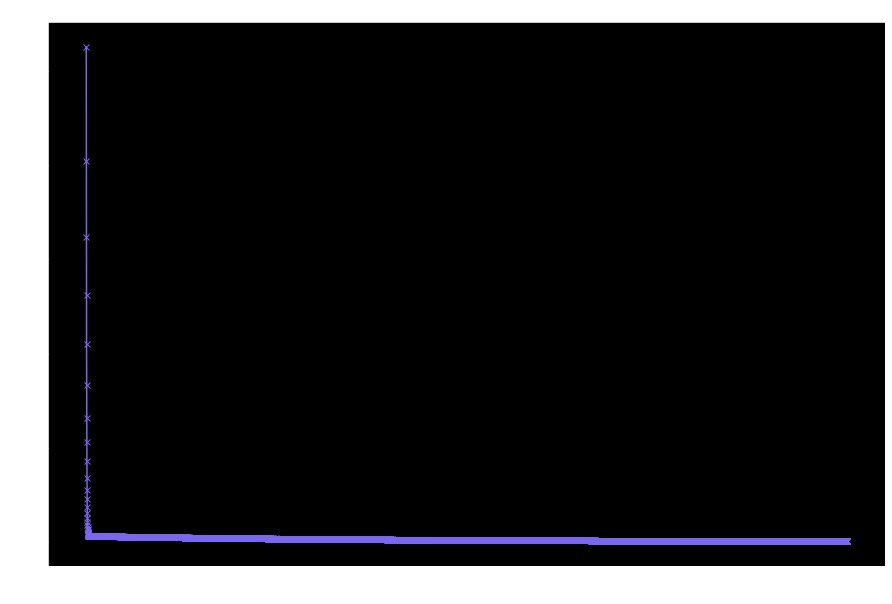

In [18]:
# losses = [r['val_loss'] for r in [result] + history1 + history2 + history3 + history4 + history5]
losses = [r['val_loss'] for r in history]
plt.figure(figsize=(15,10))
plt.style.use('dark_background')
plt.plot(losses, '-x', color='mediumslateblue')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

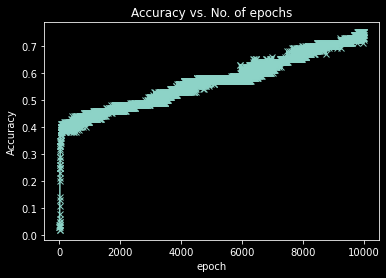

In [19]:
# accuracies = [r['val_acc'] for r in history1 + history2 + history3 + history4 + history5]
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')

# **Prediction**

In [20]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [21]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 13.0000, 328.0000, 112.0000,   4.0000,   4.0000,   4.5000,   9.1000,
          1.0000])
Target:  0.7799999713897705
Prediction: 0.4666653275489807


In [22]:
test_df = pd.read_csv('/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv')
test_df.rename(columns={'Chance of Admit ':'Chance of Admission'}, inplace=True)

# test_df.head()

# Convert from Pandas dataframe to numpy arrays
test_inputs = test_df.drop('Chance of Admission', axis=1).values
test_targets = test_df[['Chance of Admission']].values
# test_inputs.shape, test_targets.shape

# Convert to PyTorch dataset
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float32), torch.tensor(test_targets, dtype=torch.float32))
empty_ds, test_ds = random_split(test_dataset, [0, 500])

test_loader = DataLoader(test_ds, batch_size, shuffle=True)

for data in test_ds:
    x, target = data
    pred = predict_single(x, model)
    print("Input:", x)
    print("Target:", target.item())
    print("Prediction:", pred)

Input: tensor([220.0000, 312.0000, 104.0000,   3.0000,   3.5000,   3.5000,   8.4200,
          0.0000])
Target: 0.7400000095367432
Prediction: 0.5788550972938538
Input: tensor([323.0000, 314.0000, 107.0000,   2.0000,   2.5000,   4.0000,   8.2700,
          0.0000])
Target: 0.7200000286102295
Prediction: 0.7075800895690918
Input: tensor([  7.0000, 321.0000, 109.0000,   3.0000,   3.0000,   4.0000,   8.2000,
          1.0000])
Target: 0.75
Prediction: 0.5137006640434265
Input: tensor([213.0000, 338.0000, 120.0000,   4.0000,   5.0000,   5.0000,   9.6600,
          1.0000])
Target: 0.949999988079071
Prediction: 0.9140424728393555
Input: tensor([370.0000, 301.0000,  98.0000,   1.0000,   2.0000,   3.0000,   8.0300,
          1.0000])
Target: 0.6700000166893005
Prediction: 0.06450556218624115
Input: tensor([256.0000, 307.0000, 110.0000,   4.0000,   4.0000,   4.5000,   8.3700,
          0.0000])
Target: 0.7900000214576721
Prediction: 1.3798273801803589
Input: tensor([395.0000, 329.0000, 111.000

Input: tensor([169.0000, 293.0000,  97.0000,   2.0000,   2.0000,   4.0000,   7.8000,
          1.0000])
Target: 0.6399999856948853
Prediction: 0.012705236673355103
Input: tensor([420.0000, 308.0000, 102.0000,   2.0000,   2.0000,   3.5000,   7.9800,
          1.0000])
Target: 0.5799999833106995
Prediction: 0.4657406806945801
Input: tensor([ 54.0000, 324.0000, 112.0000,   4.0000,   4.0000,   2.5000,   8.1000,
          1.0000])
Target: 0.7200000286102295
Prediction: 1.4249141216278076
Input: tensor([340.0000, 324.0000, 107.0000,   5.0000,   3.5000,   4.0000,   8.6600,
          1.0000])
Target: 0.8100000023841858
Prediction: 0.7768282890319824
Input: tensor([228.0000, 312.0000, 110.0000,   2.0000,   3.5000,   3.0000,   8.5300,
          0.0000])
Target: 0.6399999856948853
Prediction: 1.2015407085418701
Input: tensor([254.0000, 335.0000, 115.0000,   4.0000,   4.5000,   4.5000,   9.6800,
          1.0000])
Target: 0.9300000071525574
Prediction: 0.6366602182388306
Input: tensor([172.0000, 3

Input: tensor([ 79.0000, 296.0000,  95.0000,   2.0000,   3.0000,   2.0000,   7.5400,
          1.0000])
Target: 0.4399999976158142
Prediction: 0.15582267940044403
Input: tensor([343.0000, 308.0000, 106.0000,   3.0000,   3.0000,   3.0000,   8.2400,
          0.0000])
Target: 0.5799999833106995
Prediction: 1.2824654579162598
Input: tensor([133.0000, 309.0000, 105.0000,   5.0000,   3.5000,   3.5000,   8.5600,
          0.0000])
Target: 0.7099999785423279
Prediction: 1.1711530685424805
Input: tensor([479.0000, 318.0000, 103.0000,   3.0000,   4.0000,   4.5000,   8.4900,
          1.0000])
Target: 0.7099999785423279
Prediction: -0.054124072194099426
Input: tensor([238.0000, 329.0000, 114.0000,   5.0000,   4.5000,   5.0000,   9.1900,
          1.0000])
Target: 0.8600000143051147
Prediction: 0.8726065158843994
Input: tensor([458.0000, 295.0000,  99.0000,   1.0000,   2.0000,   1.5000,   7.5700,
          0.0000])
Target: 0.3700000047683716
Prediction: 1.1495286226272583
Input: tensor([ 56.0000,

Input: tensor([290.0000, 313.0000, 109.0000,   3.0000,   4.0000,   3.5000,   9.0000,
          0.0000])
Target: 0.7900000214576721
Prediction: 1.040452003479004
Input: tensor([415.0000, 321.0000, 110.0000,   4.0000,   3.5000,   4.0000,   8.3500,
          1.0000])
Target: 0.7200000286102295
Prediction: 1.1155893802642822
Input: tensor([236.0000, 326.0000, 111.0000,   5.0000,   4.5000,   4.0000,   9.2300,
          1.0000])
Target: 0.8799999952316284
Prediction: 0.8966407179832458
Input: tensor([195.0000, 316.0000, 109.0000,   3.0000,   3.5000,   3.0000,   8.7600,
          0.0000])
Target: 0.7699999809265137
Prediction: 1.1223682165145874
Input: tensor([350.0000, 313.0000, 101.0000,   3.0000,   2.5000,   3.0000,   8.0400,
          0.0000])
Target: 0.6200000047683716
Prediction: 0.6209812164306641
Input: tensor([ 36.0000, 320.0000, 110.0000,   5.0000,   5.0000,   5.0000,   9.2000,
          1.0000])
Target: 0.8799999952316284
Prediction: 0.45360851287841797
Input: tensor([366.0000, 330

Input: tensor([141.0000, 329.0000, 110.0000,   2.0000,   4.0000,   3.0000,   9.1500,
          1.0000])
Target: 0.8399999737739563
Prediction: 0.26475638151168823
Input: tensor([274.0000, 312.0000,  99.0000,   1.0000,   1.0000,   1.5000,   8.0100,
          1.0000])
Target: 0.5199999809265137
Prediction: 0.32931292057037354
Input: tensor([373.0000, 336.0000, 119.0000,   4.0000,   4.5000,   4.0000,   9.6200,
          1.0000])
Target: 0.949999988079071
Prediction: 1.3464277982711792
Input: tensor([261.0000, 327.0000, 108.0000,   5.0000,   5.0000,   3.5000,   9.1300,
          1.0000])
Target: 0.8700000047683716
Prediction: 0.6411945223808289
Input: tensor([448.0000, 320.0000, 108.0000,   3.0000,   3.5000,   5.0000,   8.9700,
          1.0000])
Target: 0.8399999737739563
Prediction: 0.26996392011642456
Input: tensor([194.0000, 336.0000, 118.0000,   5.0000,   4.5000,   5.0000,   9.5300,
          1.0000])
Target: 0.9399999976158142
Prediction: 1.0356956720352173
Input: tensor([ 91.0000, 3

Input: tensor([201.0000, 317.0000, 103.0000,   3.0000,   2.5000,   3.0000,   8.5400,
          1.0000])
Target: 0.7300000190734863
Prediction: 0.3572313189506531
Input: tensor([269.0000, 327.0000, 113.0000,   4.0000,   4.5000,   5.0000,   9.1400,
          0.0000])
Target: 0.8299999833106995
Prediction: 0.7745822668075562
Input: tensor([234.0000, 304.0000, 100.0000,   2.0000,   2.5000,   3.5000,   8.0700,
          0.0000])
Target: 0.6399999856948853
Prediction: 0.29309237003326416
Input: tensor([346.0000, 316.0000,  98.0000,   1.0000,   1.5000,   2.0000,   7.4300,
          0.0000])
Target: 0.49000000953674316
Prediction: 0.21493853628635406
Input: tensor([198.0000, 310.0000, 106.0000,   2.0000,   3.5000,   2.5000,   8.3300,
          0.0000])
Target: 0.7300000190734863
Prediction: 0.9473507404327393
Input: tensor([181.0000, 300.0000, 104.0000,   3.0000,   3.5000,   3.0000,   8.1600,
          0.0000])
Target: 0.7099999785423279
Prediction: 1.123424768447876
Input: tensor([171.0000, 3

In [23]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.21989324688911438, 'val_acc': 0.7120000720024109}

# **Save and Upload**

In [24]:
torch.save(model.state_dict(), 'international-admissions-linear.pth')

In [25]:
jovian.commit(project='international-admissions-linear', environment=None, outputs=['international-admissions-linear.pth'])
jovian.commit(project='international-admissions-linear', environment=None, outputs=['international-admissions-linear.pth']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/pahuja-gor/international-admissions-linear


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/pahuja-gor/international-admissions-linear


<IPython.core.display.Javascript object>